<a href="https://colab.research.google.com/github/jbrazonath/DL/blob/main/BRAZON_JOSMAR_DL_TP3_Co22_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de Buenos Aires
# Aprendizaje Profundo - TP3
# Cohorte 22 - 5to bimestre 2025


Este tercer y último TP se debe entregar hasta las **23hs del viernes 12 de diciembre (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP3 EQUIVALE A UN TERCIO DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/kscHDArwzdvrTSG99)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP3.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP3-Co22.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

# **CLASIFICADOR DE EMOCIONES**

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/1aPHE00zkDhEV1waJKhaOJMdN6-lUc0iT/view?usp=sharing

Les recomiendo usar el siguiente código para poder obtener las imágenes fácilmente desde ese link. Pero son libres de descargar las imágenes como mejor les parezca.

In [3]:
import gdown
import zipfile
import os

url = "https://drive.google.com/uc?id=1aPHE00zkDhEV1waJKhaOJMdN6-lUc0iT"
output = "archivo.zip"

gdown.download(url, output, quiet=False)

destino = "datos_zip"
os.makedirs(destino, exist_ok=True)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(destino)

DATASET_ROOT_TRAIN = '/content/datos_zip/dataset_emociones/train'
DATASET_ROOT_VAL   = '/content/datos_zip/dataset_emociones/validation'


Downloading...
From (original): https://drive.google.com/uc?id=1aPHE00zkDhEV1waJKhaOJMdN6-lUc0iT
From (redirected): https://drive.google.com/uc?id=1aPHE00zkDhEV1waJKhaOJMdN6-lUc0iT&confirm=t&uuid=56734ff4-9ba0-4655-806a-c72af2dd9aac
To: /content/archivo.zip
100%|██████████| 40.0M/40.0M [00:01<00:00, 35.6MB/s]


## 1. Preprocesamiento de Datos (2 puntos)

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan solo las técnicas que consideren pertinentes para este caso de uso en específico.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento. Lean su documentación si tienen dudas: https://docs.pytorch.org/vision/0.14/transforms.html



In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(
    root=str(DATASET_ROOT_TRAIN),
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=str(DATASET_ROOT_VAL),
    transform=val_transform
)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
print("clases:", class_names)

train_counts = Counter([label for _, label in train_dataset])
print("cantidad de imágenes por clase (train):")
for idx, cls in enumerate(class_names):
    print(cls, ":", train_counts[idx])


clases: ['alegria', 'disgusto', 'enojo', 'miedo', 'seriedad', 'sorpresa', 'tristeza']
cantidad de imágenes por clase (train):
alegria : 4772
disgusto : 717
enojo : 705
miedo : 281
seriedad : 2524
sorpresa : 1290
tristeza : 1982


In [5]:
import torch
import numpy as np

# 1. Extraer los conteos en orden
conteos = list(train_counts.values())

# 2. Calcular pesos (Inverso de la frecuencia)
total_muestras = sum(conteos)
class_weights = [total_muestras / c for c in conteos]

# Convertir a Tensor
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"Pesos calculados: {class_weights}")

Pesos calculados: [2.571458507963118, 17.11436541143654, 17.405673758865248, 43.669039145907476, 4.8617274167987325, 9.512403100775193, 6.191220988900101]


Dado el alto desbalance entre emociones (por ejemplo: alegría 4772 vs miedo 281), se aplicó una pérdida ponderada con pesos inversamente proporcionales a la frecuencia de cada clase. Esto evita que el modelo quede sesgado hacia la clase mayoritaria

## 2. Construcción y entrenamiento del Modelo CNN (3.5 puntos)

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, número y tamaño de los kernels, entre otros, queda a criterio de ustedes, pero deben estar justificadas.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MiCNN(nn.Module):
    def __init__(self, num_classes):
        super(MiCNN, self).__init__()

        # BLOQUE 1: bordes / texturas simples
        # Entrada: 1 canal (gris), Salida: 32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 -> 64

        # BLOQUE 2: patrones más complejos
        # 64 -> 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # BLOQUE 3: rasgos de alto nivel (configuración global de la cara)
        # 32 -> 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        #TENIA 3 BLOQUES, AGREGARÉ UNO NUEVO A VER SI MEJORA MI MODELO
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        # CLASIFICADOR
        self.flatten_dim = 256 * 8 * 8

        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x)))) # Nueva capa

        x = x.view(-1, self.flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_clases = len(class_names)
model = MiCNN(num_classes=num_clases)
print(model)


MiCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)


## 3. Evaluación del Modelo (2.5 puntos)

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.


Epoch 1/20 - Train Loss: 1.8587, Val Loss: 1.6632 - Train Acc: 0.2798, Val Acc: 0.4400 - Train F1: 0.2958, Val F1: 0.4187
Epoch 2/20 - Train Loss: 1.6453, Val Loss: 1.5615 - Train Acc: 0.3923, Val Acc: 0.4309 - Train F1: 0.4080, Val F1: 0.4628
Epoch 3/20 - Train Loss: 1.5322, Val Loss: 1.2341 - Train Acc: 0.4542, Val Acc: 0.5994 - Train F1: 0.4635, Val F1: 0.5945
Epoch 4/20 - Train Loss: 1.4686, Val Loss: 1.2561 - Train Acc: 0.4694, Val Acc: 0.5179 - Train F1: 0.4816, Val F1: 0.5587
Epoch 5/20 - Train Loss: 1.3666, Val Loss: 1.0488 - Train Acc: 0.5117, Val Acc: 0.6274 - Train F1: 0.5249, Val F1: 0.6347
Epoch 6/20 - Train Loss: 1.3081, Val Loss: 1.0827 - Train Acc: 0.5314, Val Acc: 0.6089 - Train F1: 0.5508, Val F1: 0.6248
Epoch 7/20 - Train Loss: 1.2490, Val Loss: 1.0641 - Train Acc: 0.5352, Val Acc: 0.6362 - Train F1: 0.5553, Val F1: 0.6436
Epoch 8/20 - Train Loss: 1.2124, Val Loss: 1.0145 - Train Acc: 0.5600, Val Acc: 0.6402 - Train F1: 0.5797, Val F1: 0.6548
Epoch 9/20 - Train Loss:

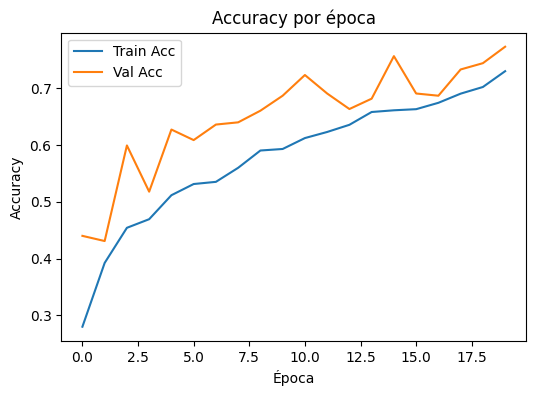

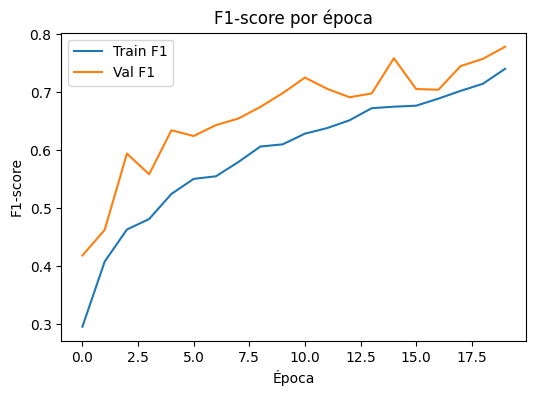

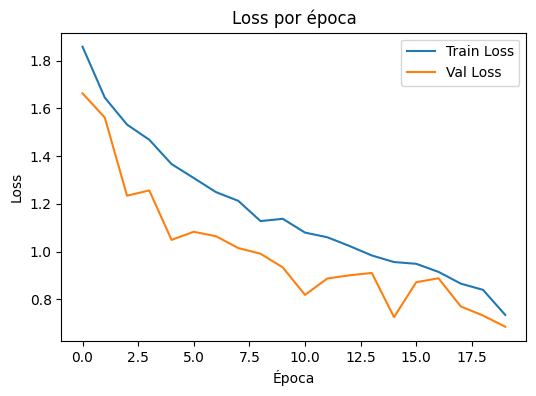


=== CLASSIFICATION REPORT (VALIDACIÓN) ===
              precision    recall  f1-score   support

     alegria       0.93      0.88      0.90      1185
    disgusto       0.40      0.53      0.45       160
       enojo       0.68      0.75      0.71       162
       miedo       0.44      0.65      0.52        74
    seriedad       0.77      0.70      0.73       680
    sorpresa       0.76      0.80      0.78       329
    tristeza       0.71      0.71      0.71       478

    accuracy                           0.77      3068
   macro avg       0.67      0.72      0.69      3068
weighted avg       0.79      0.77      0.78      3068



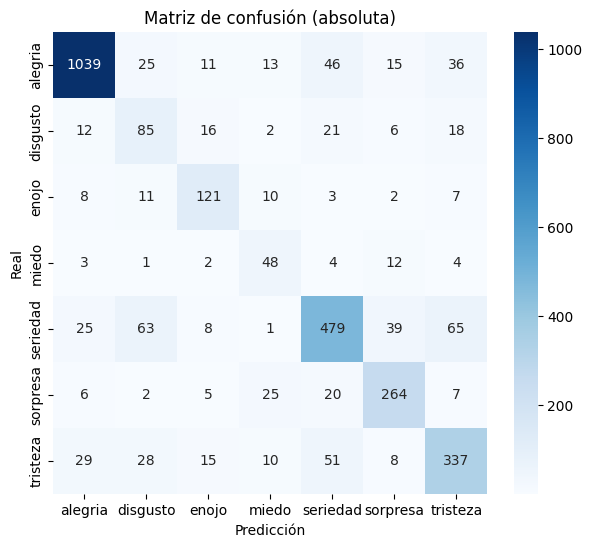

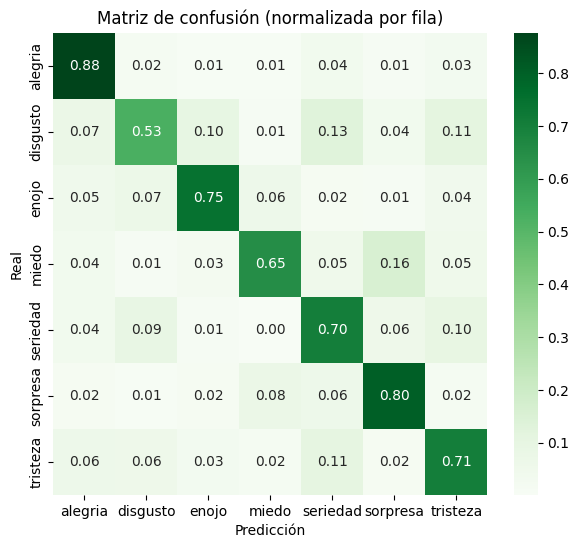

In [8]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# DEVICE Y PESOS DE CLASE
# -----------------------------
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
class_weights_tensor = class_weights_tensor.to(device)

model = MiCNN(num_classes=num_clases).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

warmup_epochs = 3

scheduler_warmup = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=0.2,
    total_iters=warmup_epochs
)

scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=3
)

# -----------------------------
# HISTORIA DE MÉTRICAS
# -----------------------------
train_loss_hist = []
val_loss_hist   = []
train_acc_hist  = []
val_acc_hist    = []
train_f1_hist   = []
val_f1_hist     = []

epochs = 20

for epoch in range(epochs):
    model.train()
    train_losses = []
    train_preds  = []
    train_labels = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss = np.mean(train_losses)
    train_acc  = accuracy_score(train_labels, train_preds)
    train_f1   = f1_score(train_labels, train_preds, average="weighted")

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    train_f1_hist.append(train_f1)

    # -------------------------
    # VALIDACIÓN
    # -------------------------
    model.eval()
    val_losses = []
    val_preds  = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_losses.append(loss.item())

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = np.mean(val_losses)
    val_acc  = accuracy_score(val_labels, val_preds)
    val_f1   = f1_score(val_labels, val_preds, average="weighted")

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    val_f1_hist.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs} "
          f"- Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} "
          f"- Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} "
          f"- Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

    if epoch < warmup_epochs:
        scheduler_warmup.step()
    else:
        scheduler_plateau.step(val_loss)

# ------------------------------------------------------------------
# 1) MÉTRICAS FINALES EN VALIDACIÓN
# ------------------------------------------------------------------
final_val_acc = val_acc_hist[-1]
final_val_f1  = val_f1_hist[-1]

print(f"\nAccuracy final validación: {final_val_acc:.4f}")
print(f"F1-score final validación: {final_val_f1:.4f}")

# ------------------------------------------------------------------
# 2) GRÁFICAS: ACCURACY, F1, LOSS
# ------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_f1_hist, label="Train F1")
plt.plot(val_f1_hist, label="Val F1")
plt.title("F1-score por época")
plt.xlabel("Época")
plt.ylabel("F1-score")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Loss por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ------------------------------------------------------------------
# 3) CLASSIFICATION REPORT
#    (usamos val_labels y val_preds de la ÚLTIMA época)
# ------------------------------------------------------------------
print("\n=== CLASSIFICATION REPORT (VALIDACIÓN) ===")
print(classification_report(val_labels, val_preds, target_names=class_names))

# ------------------------------------------------------------------
# 4) MATRICES DE CONFUSIÓN
# ------------------------------------------------------------------
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.title("Matriz de confusión (absoluta)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

cm_norm = confusion_matrix(val_labels, val_preds, normalize="true")

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Greens")
plt.title("Matriz de confusión (normalizada por fila)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


 ## 4. Prueba de Imágenes Nuevas (1 punto)
Subir al menos 10 imágenes personales de cualquier relación de aspecto (pueden usar fotos del rostro de ustedes, rostros de personas generadas por IA o imágenes stock de internet), que no formen parte del dataset de entrenamiento ni de validación.

- Debe haber al menos una imagen para cada emoción.

- Aplicar el mismo pre-procesamiento que se usó para el dataset de validation durante el entrenamiento del modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase (normalizado de 0 a 1 o de 0% a 100%)
  - La clase ganadora inferida por el modelo

- Redactar conclusiones preliminares

In [9]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

# mismo preprocesamiento que VALIDATION
transform_test = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dir = "test_images"  # carpeta que subiste al repo

def predict_image(path):
    # imagen original
    img = Image.open(path).convert("RGB")
    original = np.array(img)

    # pre-procesada
    img_t = transform_test(img)
    img_t = img_t.unsqueeze(0).to(device)  # [1, 1, 64, 64]

    model.eval()
    with torch.no_grad():
        outputs = model(img_t)
        probs = F.softmax(outputs, dim=1).cpu().numpy()[0]

    pred_idx = probs.argmax()
    pred_class = class_names[pred_idx]
    return original, img_t.squeeze().cpu().numpy(), probs, pred_class

# tomamos todas las imágenes de la carpeta (o las primeras 10 si hay más)
image_files = [
    f for f in os.listdir(test_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]
image_files = sorted(image_files)[:10]  # mínimo 10 para el TP

for filename in image_files:
    path = os.path.join(test_dir, filename)
    original, processed, probs, pred_class = predict_image(path)

    print("\n==============================")
    print("Imagen:", filename)
    print("Clase predicha:", pred_class)
    print("Scores por clase (0–100%):")
    for cls, p in zip(class_names, probs):
        print(f"  {cls:9s}: {p*100:5.2f}%")

    # mostrar original y preprocesada
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.title("Imagen original")
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Imagen pre-procesada")
    plt.imshow(processed, cmap="gray")
    plt.axis("off")

    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'test_images'

 ## 5. Prueba de Imágenes Nuevas con Pre-procesamiento Adicional (1 punto)
Las 10 imágenes del punto 4, ahora serán pasadas y recortadas por un algoritmo de detección de rostros. Usen el siguiente código para realizar un pre-procesamiento inicial de la imagen y ya luego aplican el pre-procesamiento que usaron al momento de entrenar el modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:
  - La imagen original
  - La imagen recortada por el algoritmo
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase (normalizado de 0 a 1 o de 0% a 100%)
  - La clase ganadora inferida por el modelo

- Comparar los resultados con el punto 4 y redactar conclusiones finales.

NOTA: Pueden adaptar el código y modificar el `scaleFactor` y el `minNeighbors` según crean conveniente para obtener mejores resultados.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image_path = ""

image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6)

image_with_box = image.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

cropped_face_rgb = None
if len(faces) > 0:
    (x, y, w, h) = faces[0]
    center_x, center_y = x + w // 2, y + h // 2
    side = max(w, h)
    half_side = side // 2

    x1 = max(center_x - half_side, 0)
    y1 = max(center_y - half_side, 0)
    x2 = min(center_x + half_side, image.shape[1])
    y2 = min(center_y + half_side, image.shape[0])

    cropped_face = image[y1:y2, x1:x2]
    cropped_face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

image_with_box_rgb = cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_with_box_rgb)
ax[0].set_title("Detección")
ax[0].axis('off')

if cropped_face_rgb is not None:
    ax[1].imshow(cropped_face_rgb)
    ax[1].set_title("Rostro recortado (relación aspecto 1:1)")
    ax[1].axis('off')
else:
    ax[1].text(0.5, 0.5, 'No se detectó rostro', horizontalalignment='center', verticalalignment='center')
    ax[1].axis('off')

plt.tight_layout()
plt.show()
